In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale, StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Exercise 1

## Read [USArrests](https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Data/USArrests.csv) dataset for [PCA](https://uc-r.github.io/pca) analysis

This dataset contains four variables that represent the number of arrests per 100,000 residents for Assault, Murder, and Rape in each of the fifty US states in 1973. The data set also contains the percentage of the population living in urban areas, UrbanPop.

In [4]:
USArrests = pd.read_csv('https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/USArrests.csv',
                        skiprows=1,
                        names=['State', 'Murder', 'Assault', 'UrbanPop', 'Rape'])[['State', 'Assault', 'Murder', 'Rape', 'UrbanPop']]
USArrests.head()

,State,Assault,Murder,Rape,UrbanPop
0,Alabama,236,13.2,21.2,58
1,Alaska,263,10.0,44.5,48
2,Arizona,294,8.1,31.0,80
3,Arkansas,190,8.8,19.5,50
4,California,276,9.0,40.6,91


In [5]:
# compute variance of each variable
USArrests.iloc[:,1:].var().round(1)

Assault     6945.2
Murder        19.0
Rape          87.7
UrbanPop     209.5
dtype: float64

It is usually beneficial for each variable to be centered at zero for PCA, due to the fact that it makes comparing each principal component to the mean straightforward. This also eliminates potential problems with the scale of each variable.

PCA is influenced by the magnitude of each variable; therefore, the results obtained when we perform PCA will also depend on whether the variables have been individually scaled.

## Step 1: Standardize the numeric columns

Standardize each of the numeric variables: `assault`, `murder`, `rape`, and `urban pop`.

In [6]:
# normalize dataset
df_scaled = USArrests.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std())

# alternatively, using StandardScaler
# ss = StandardScaler()
# df_scaled = ss.fit_transform(USArrests.iloc[:,1:].values)
# df_scaled = pd.DataFrame(df_scaled, columns=['Murder', 'Assault', 'UrbanPop', 'Rape'])

df_scaled.head()

,Assault,Murder,Rape,UrbanPop
0,0.782839,1.242564,-0.003416,-0.520907
1,1.106823,0.507862,2.484203,-1.211764
2,1.478803,0.071633,1.042878,0.998980
3,0.230868,0.232349,-0.184917,-1.073593
4,1.262814,0.278268,2.067820,1.758923


## Step 2: Create a PCA instance with 2 components and fit it to the standardized data

In [69]:
# create an instance of the PCA class
pca = PCA(n_components=2)

# fit the data
pca_skl = pca.fit_transform(df_scaled)

# display as a DataFrame
pd.DataFrame(pca_skl, index=USArrests.State, columns=['PC1', 'PC2']).head()

,PC1,PC2
State,,
Alabama,0.975660,1.122001
Alaska,1.930538,1.062427
Arizona,1.745443,-0.738460
Arkansas,-0.139999,1.108542
California,2.498613,-1.527427


## Step 3: Inspect the loadings for the first and second principal components, stored in the `pca.components_` attribute

In [70]:
pd.DataFrame(pca.components_, columns=pca.feature_names_in_, index=['PC1', 'PC2']).T

,PC1,PC2
Murder,0.535899,0.418181
Assault,0.583184,0.187986
UrbanPop,0.278191,-0.872806
Rape,0.543432,-0.167319


By examining the principal component vectors above, we can infer that the first principal component (PC1) roughly corresponds to an overall rate of serious crimes since Murder, Assault, and Rape have the largest values.

The second component (PC2) is affected by UrbanPop more than the other three variables, so it roughly corresponds to the level of urbanization of the state, with some opposite, smaller influence by murder rate.

## Step 4: Plot the first (x-axis) and second (y-axis) principal components to produce a two-dimensional view of the data

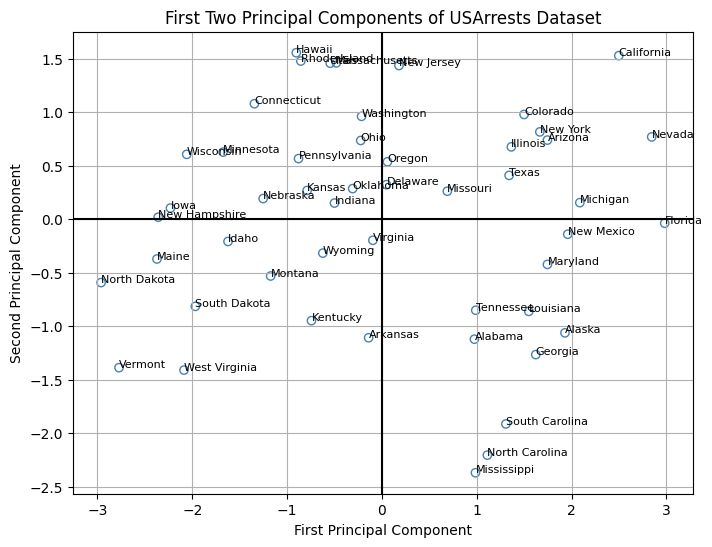

In [80]:
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(pca_skl[:, 0], pca_skl[:, 1]*-1, facecolors='none', edgecolors='steelblue')

for i, state in enumerate(USArrests.State):
    ax.annotate(state, (pca_skl[i, 0], pca_skl[i, 1]*-1), fontsize=8)

plt.axvline(c='k', linestyle='solid')
plt.axhline(c='k', linestyle='solid')
plt.grid()

plt.title("First Two Principal Components of USArrests Dataset")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component");

# Exercise 2

## Read [mtcars]("https://raw.githubusercontent.com/Statology/Python-Guides/main/mtcars.csv") dataset for [PCA](https://www.statology.org/principal-components-regression-in-python/) regression analysis

This dataset contains information about 33 different cars. We will use `mpg` as the response variable and the following variables as the predictors: `hp`, `disp`, `drat`, `wt`, `qsec`.

In [25]:
mtcars_raw = pd.read_csv('https://raw.githubusercontent.com/Statology/Python-Guides/main/mtcars.csv')

mtcars = mtcars_raw[["mpg", "disp", "drat", "wt", "qsec", "hp"]]
mtcars.head()

,mpg,disp,drat,wt,qsec,hp
0,21.0,160.0,3.90,2.620,16.46,110
1,21.0,160.0,3.90,2.875,17.02,110
2,22.8,108.0,3.85,2.320,18.61,93
3,21.4,258.0,3.08,3.215,19.44,110
4,18.7,360.0,3.15,3.440,17.02,175


## Step 1: Separate `y` and `X`, label and features

In [26]:
X = mtcars.iloc[:, 1:]

y = mtcars.iloc[:, 1]

X.shape, y.shape

((32, 5), (32,))

## Step 2: Standardize the feature columns

Standardize each of the numeric features: `mpg`, `disp`, `drat`, `wt` and `qsec`.

In [27]:
# normalize dataset
X_scaled = X.apply(lambda x: (x - x.mean()) / x.std())

# alternatively, using StandardScaler
# ss = StandardScaler()
# X_scaled = ss.fit_transform(mtcars.iloc[:,:1].values)
# X_scaled = pd.DataFrame(X_scaled, columns=["mpg", "disp", "drat", "wt", "qsec"])

X_scaled.head()

,disp,drat,wt,qsec,hp
0,-0.570620,0.567514,-0.610400,-0.777165,-0.535093
1,-0.570620,0.567514,-0.349785,-0.463781,-0.535093
2,-0.990182,0.474000,-0.917005,0.426007,-0.783040
3,0.220094,-0.966118,-0.002300,0.890487,-0.535093
4,1.043081,-0.835198,0.227654,-0.463781,0.412942


## Step 3: Create a PCA instance with 2 components and fit it to the standardized data

In [28]:
# create an instance of the PCA class
pca = PCA(n_components=2)

# fit the data
X_pca = pca.fit_transform(X_scaled)

# display as a DataFrame
pd.DataFrame(X_pca, index=mtcars_raw.model, columns=['PC1', 'PC2']).head()

,PC1,PC2
model,,
Mazda RX4,0.856899,0.904102
Mazda RX4 Wag,0.823709,0.585623
Datsun 710,1.663085,0.006144
Hornet 4 Drive,0.009737,-1.312593
Hornet Sportabout,-1.338955,-0.054606


In [29]:
print(pca.explained_variance_, pca.explained_variance_ratio_)

[3.33874601 1.1433445 ] [0.6677492 0.2286689]


## Step 4:

### 4a. Instantiate a RepeatedKFold object with `n_splits=10`, `n_repeats=3`, `random_state=1`

### 4b. Instantiate a LinearRegression object

### 4c. Use `your LinearRegression object`, `X_pca`, `y`, `your RepeatedKFold object`, and `scoring='neg_root_mean_squared_error'` inside [cross_val_score](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics) to estimate the out-of-sample root mean squared error (RMSE) of your PCA regression.



In [44]:
# Define a cross validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# Instantiate a LinearRegression
regr = LinearRegression()

# Calculate RMSE with only PC1 and PC2 ( np.ones((1, len(X_pca))) )
pca_scores = cross_val_score(regr, X_pca, y, cv=cv, scoring='neg_root_mean_squared_error')
print("PCA: %0.2f RMSE with a standard deviation of %0.2f." % (pca_scores.mean(), pca_scores.std()))

PCA: -33.50 RMSE with a standard deviation of 15.43.


## Extra: In-sample Results

In [39]:
results = sm.OLS(y, X_pca).fit()
print(results.summary2())

                       Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.151   
Dependent Variable:     disp             AIC:                         443.6400
Date:                   2024-06-24 13:21 BIC:                         446.5715
No. Observations:       32               Log-Likelihood:              -219.82 
Df Model:               2                F-statistic:                 3.842   
Df Residuals:           30               Prob (F-statistic):          0.0327  
R-squared (uncentered): 0.204            Scale:                       57839.  
----------------------------------------------------------------------------------
            Coef.       Std.Err.        t        P>|t|        [0.025       0.975] 
----------------------------------------------------------------------------------
x1         -65.2387      23.6394     -2.7597     0.0098     -113.5168     -16.9606
x2         -10.5672      40.3961     -0.2616     0.7954     